In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [20]:
def replace_outliers_with_median(df):
    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Sostituisci gli outlier con la mediana
            median = df_clean[col].median()
            df_clean[col] = df_clean[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df_clean


In [21]:
def remove_outliers(df):

    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Rimuovi gli outlier
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

In [22]:
def new_quality_value(df):
    
    new_df = df.copy()
    # Mappa i valori della colonna 'quality' 
    quality_mapping = {3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2}
    new_df['quality'] = new_df['quality'].replace(quality_mapping)
    
    return new_df


In [58]:
def classificator (dataset, classifier, testsize):
    accuracy_dict={}
    x_data=dataset.drop(columns=[classifier])
    y_data=dataset.loc[:,classifier]
    x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=testsize,random_state=10)

    accuracy_dict['Type']= testsize
    accuracy_dict['Size']= dataset.shape[0]
    # RandomForestClassifier 
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=20)
    rf_model.fit(x_train, y_train)

    y_pred = rf_model.predict(x_test)

    # Valutazione delle prestazioni del modello
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello RandomForestClassifier: %.3f" %accuracy)
    accuracy_dict['RandomForest']=round(accuracy,3)

    # Classificatore SVM con solo relevant feature
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

    svm_classifier.fit(x_train, y_train)
    y_pred = svm_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore SVM: %.3f" %accuracy)
    accuracy_dict['SVM']=round(accuracy,3)

    # Crea il modello di regressione logistica con solo relevant
    logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42)

    logistic_regression.fit(x_train, y_train)
    y_pred = logistic_regression.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello di regressione logistica: %.3f" %accuracy)
    accuracy_dict['Regression']=accuracy

    # DecisionTreeClassifier con tutte le feature
    tree_classifier = DecisionTreeClassifier(random_state=42)

    tree_classifier.fit(x_train, y_train)
    y_pred = tree_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore ad albero decisionale: %.3f" %accuracy)
    accuracy_dict['Tree']=round(accuracy,3)


    # Classificatore naive bayes con relevant feature
    naive_bayes_classifier = GaussianNB()
    naive_bayes_classifier.fit(x_train, y_train)

    y_pred = naive_bayes_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore Naive Bayes: %.3f" %accuracy)
    accuracy_dict['Bayes']=round(accuracy,3)

    return accuracy_dict


In [47]:
def classification_evo(dataframe, testsize):

    data=dataframe.copy()

    data_clean=replace_outliers_with_median(data)
    data_clean_remove=remove_outliers(data)

    relevant=dataframe.drop(columns=['fixed_acidity','residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH'])
    relevant_clean=replace_outliers_with_median(relevant)
    relevant_clean_remove=remove_outliers(relevant)

    result=pd.DataFrame()

    result['Data']=classificator(data,'quality',testsize)

    result['Relevant']=classificator(relevant,'quality', testsize)

    result['Data_Clean']=classificator(data_clean,'quality', testsize)

    result['Relevant_Clean']=classificator(relevant_clean, 'quality', testsize)

    result['Data_Remove']=classificator(data_clean_remove,'quality', testsize)

    result['Relevant_Remove']=classificator(relevant_clean_remove, 'quality', testsize)

    new_data=new_quality_value(data)

    result['New_Data']=classificator(new_data,'quality', testsize)

    relevant_new=new_data.drop(columns=['fixed_acidity','residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH'])
    result['New_Relevant']=classificator(relevant_new,'quality', testsize)

    data_clean_new=replace_outliers_with_median(new_data)
    result['New_Data_Clean']=classificator(data_clean_new,'quality', testsize)

    relevant_clean_new=replace_outliers_with_median(relevant_new)
    result['New_Relevant_Clean']=classificator(relevant_clean_new,'quality', testsize)

    data_clean_new_remove=remove_outliers(new_data)
    result['New_Data_Remove']=classificator(data_clean_new_remove,'quality', testsize)

    relevant_new_remove=remove_outliers(relevant_new)
    result['New_Relevant_Remove']=classificator(relevant_new_remove,'quality', testsize)

    return result


In [63]:
def plot_result_evo(res):
    num=res.iloc[1]
    result=res.drop(index= ['Size','Type'])
    num_cols = len(result.columns)
    num_rows = (num_cols + 1) // 2 

    # Creazione del grafico a barre
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

    # Itera sul DataFrame e crea i subplot
    for i, (col_name, col_data) in enumerate(result.items()):
        row = i // 2
        col = i % 2
        keys = result.index
        values = col_data
        colors = plt.cm.RdBu(np.array(values) / max(values))
        
        for j, v in enumerate(values):
            axs[row, col].text(j, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
        
        axs[row, col].bar(keys, values, color=colors)
        axs[row, col].set_ylabel('Valori')
        axs[row, col].set_title('Dataset name='+col_name+'   Dataset size='+str(num.iloc[i]))
        axs[row, col].set_xticks(keys)
        axs[row, col].set_xticklabels(keys, rotation=45, ha='right')
        axs[row, col].set_ylim(0, max(values) * 1.2)

    # Rimuovi i subplot non utilizzati
    for i in range(num_cols, num_rows*2):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()


In [29]:
wine_dataframe = pd.read_csv('restore_winedata.csv')
result={}
data=wine_dataframe.copy()
data.shape

(1599, 12)

In [66]:
result['r_10']=classification_evo(data,0.10)

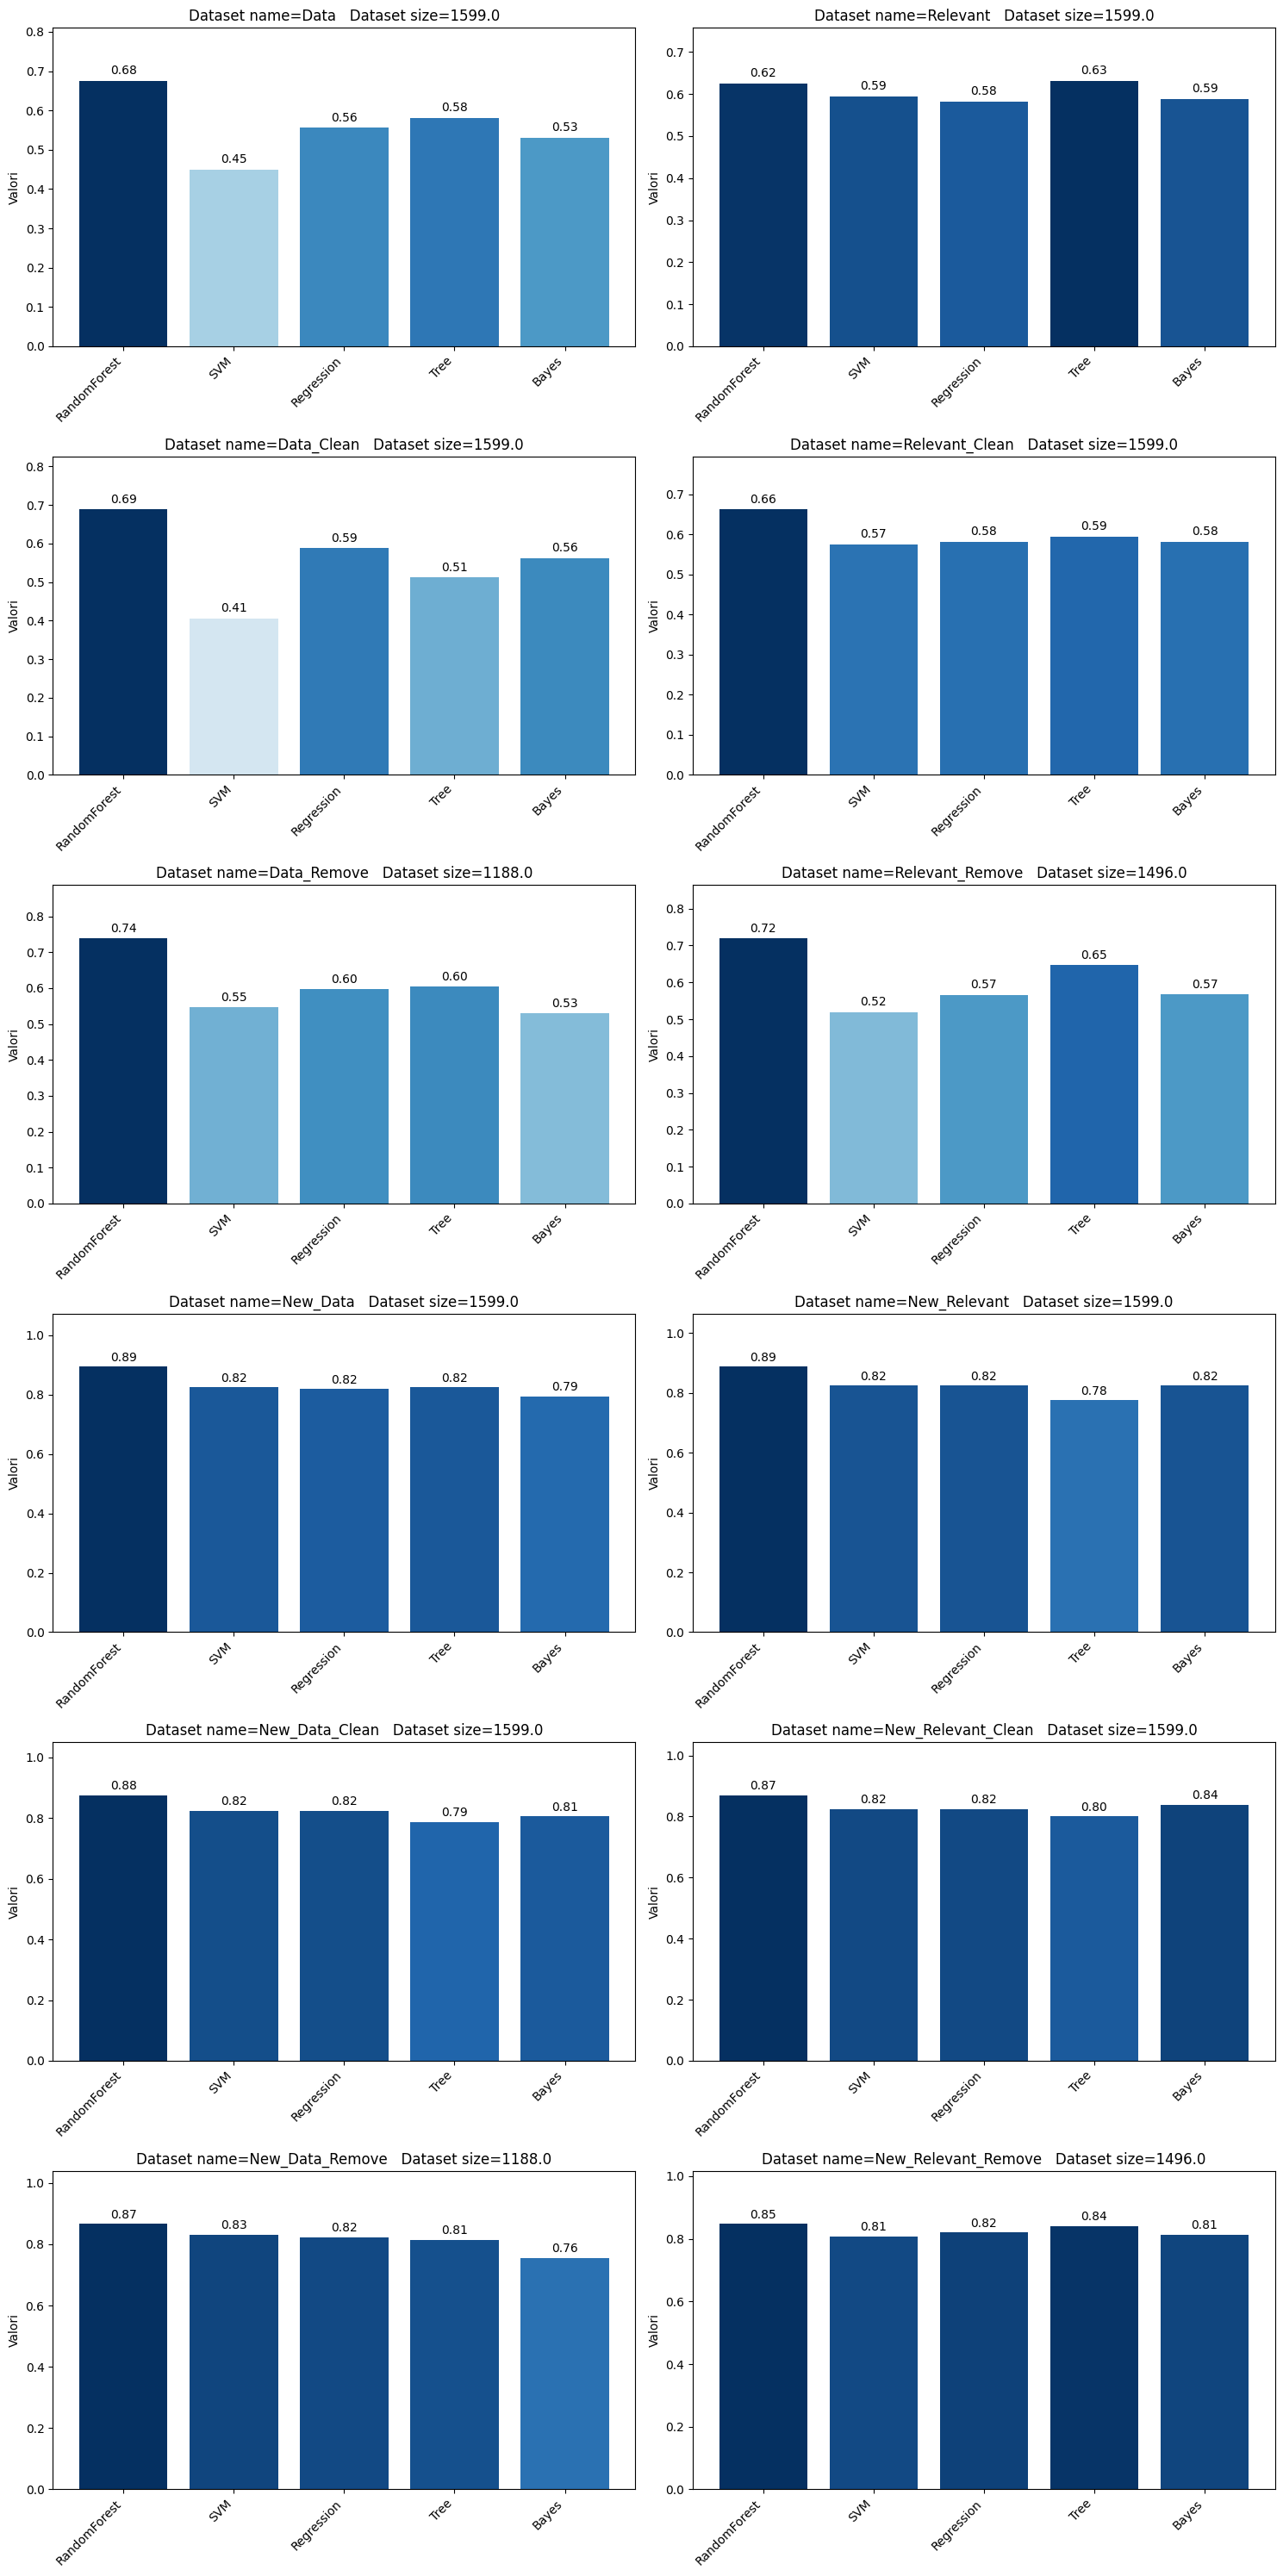

In [65]:
plot_result_evo(result['r_10'])

In [67]:
result['r_15']=classification_evo(data,0.15)

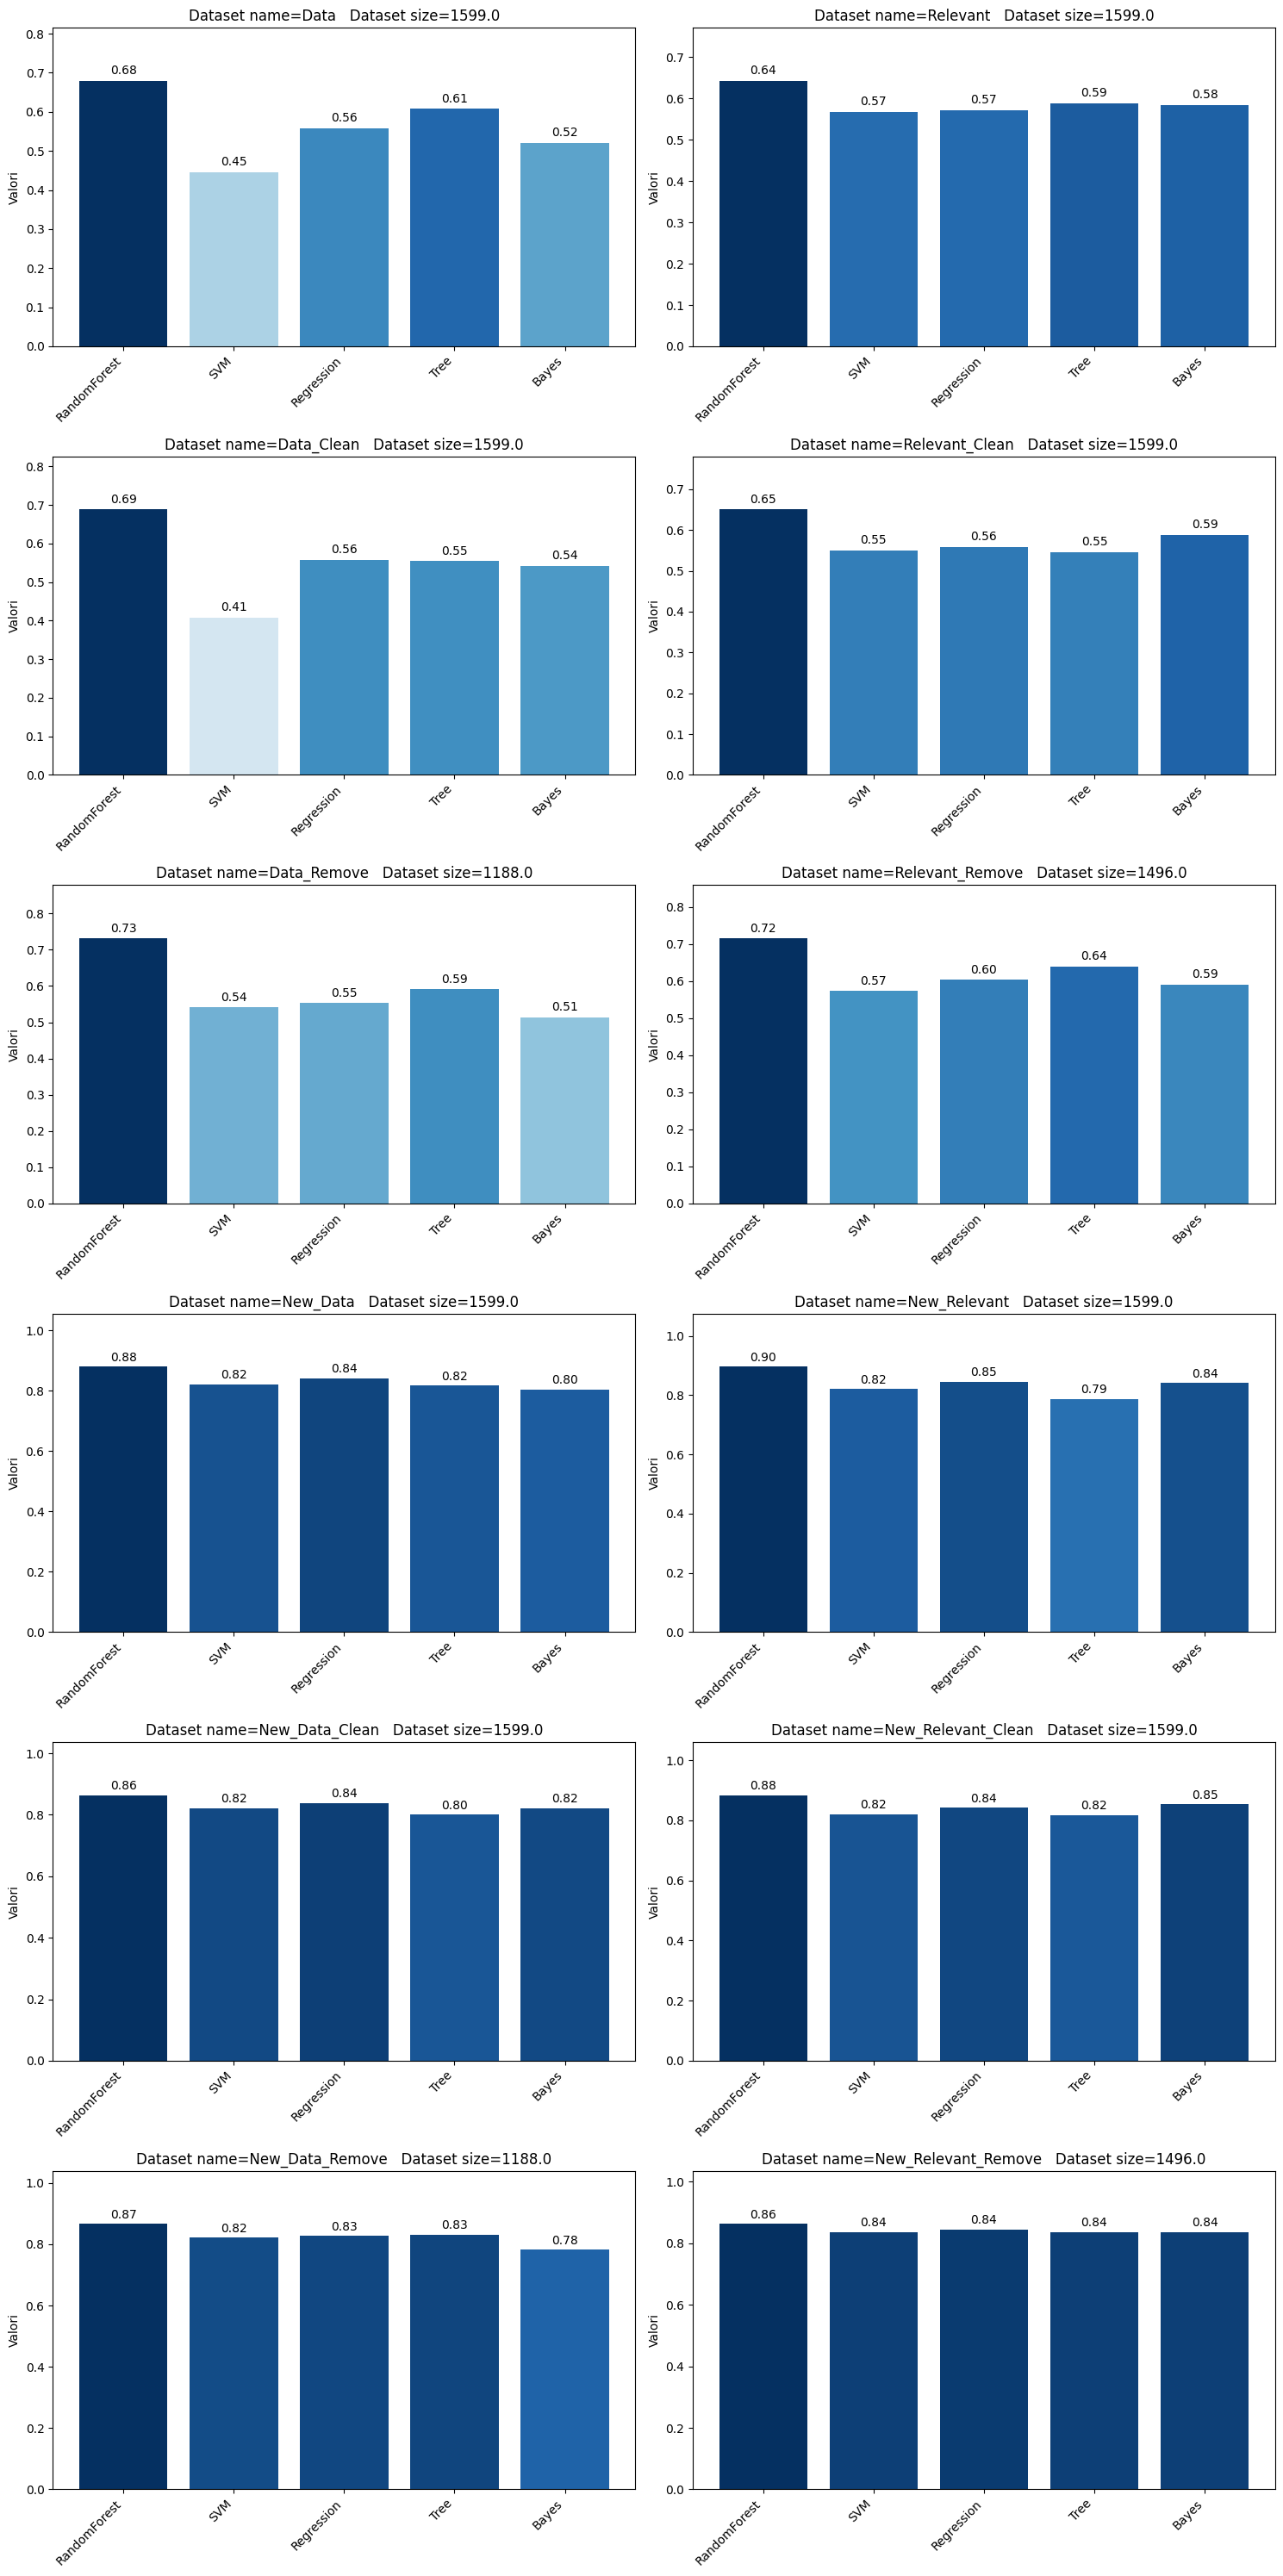

In [69]:
plot_result_evo(result['r_15'])

In [70]:
result['r_20']=classification_evo(data,0.20)

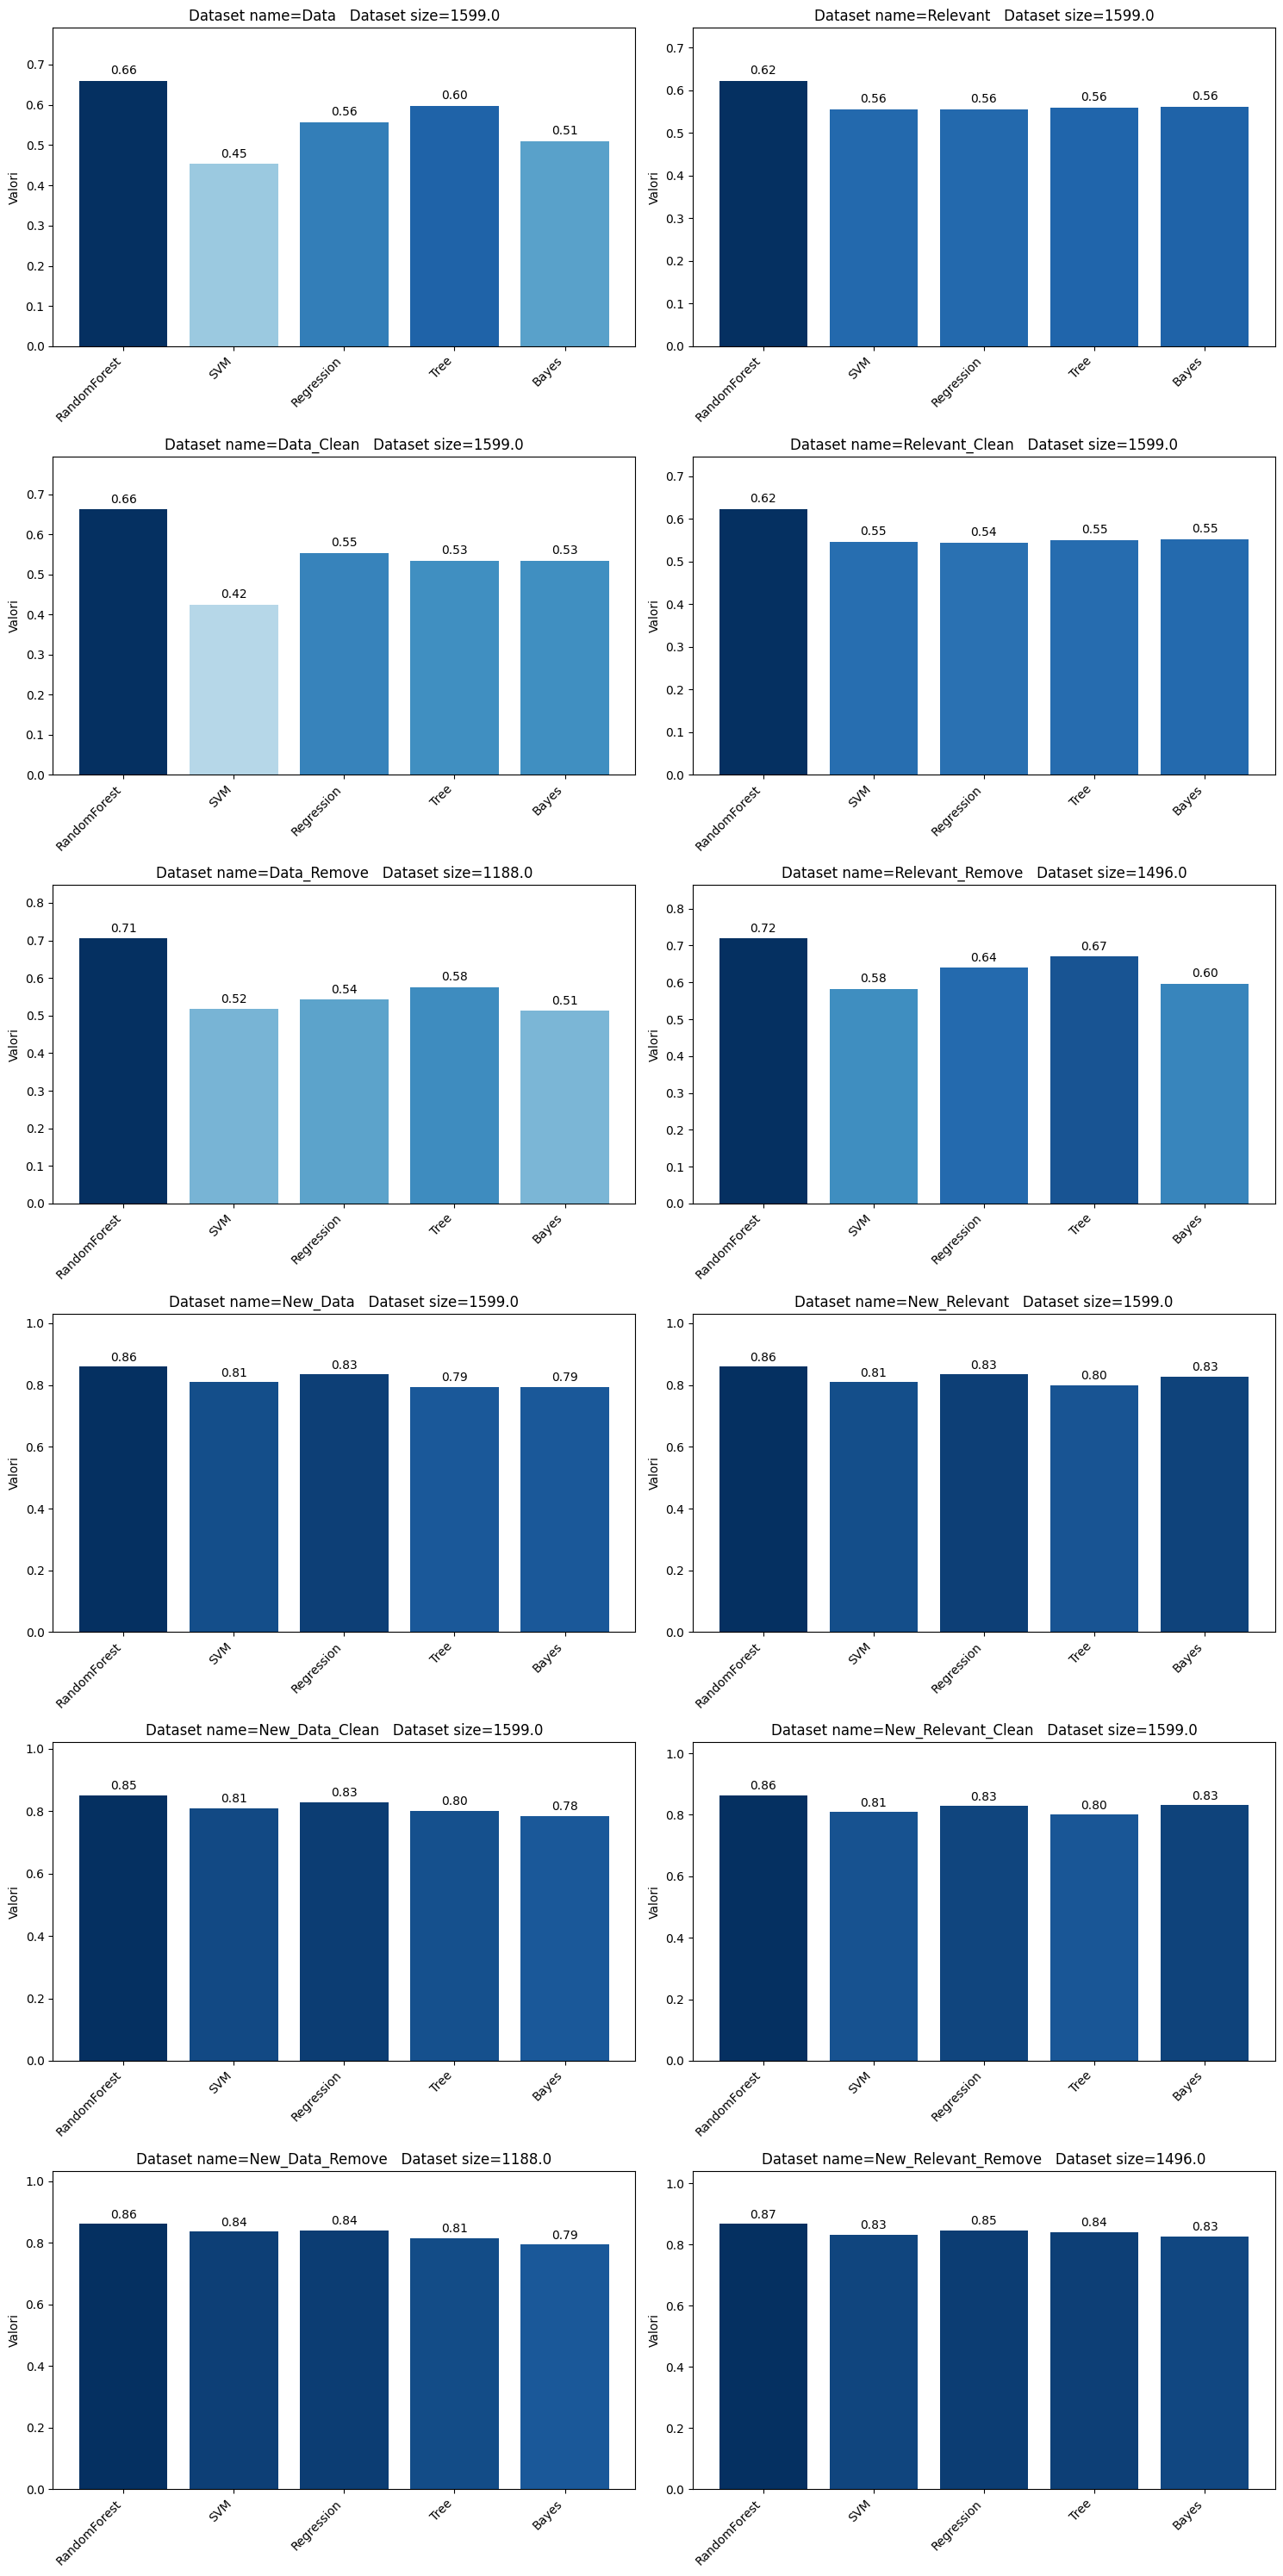

In [71]:
plot_result_evo(result['r_20'])

In [72]:
result['r_25']=classification_evo(data,0.25)

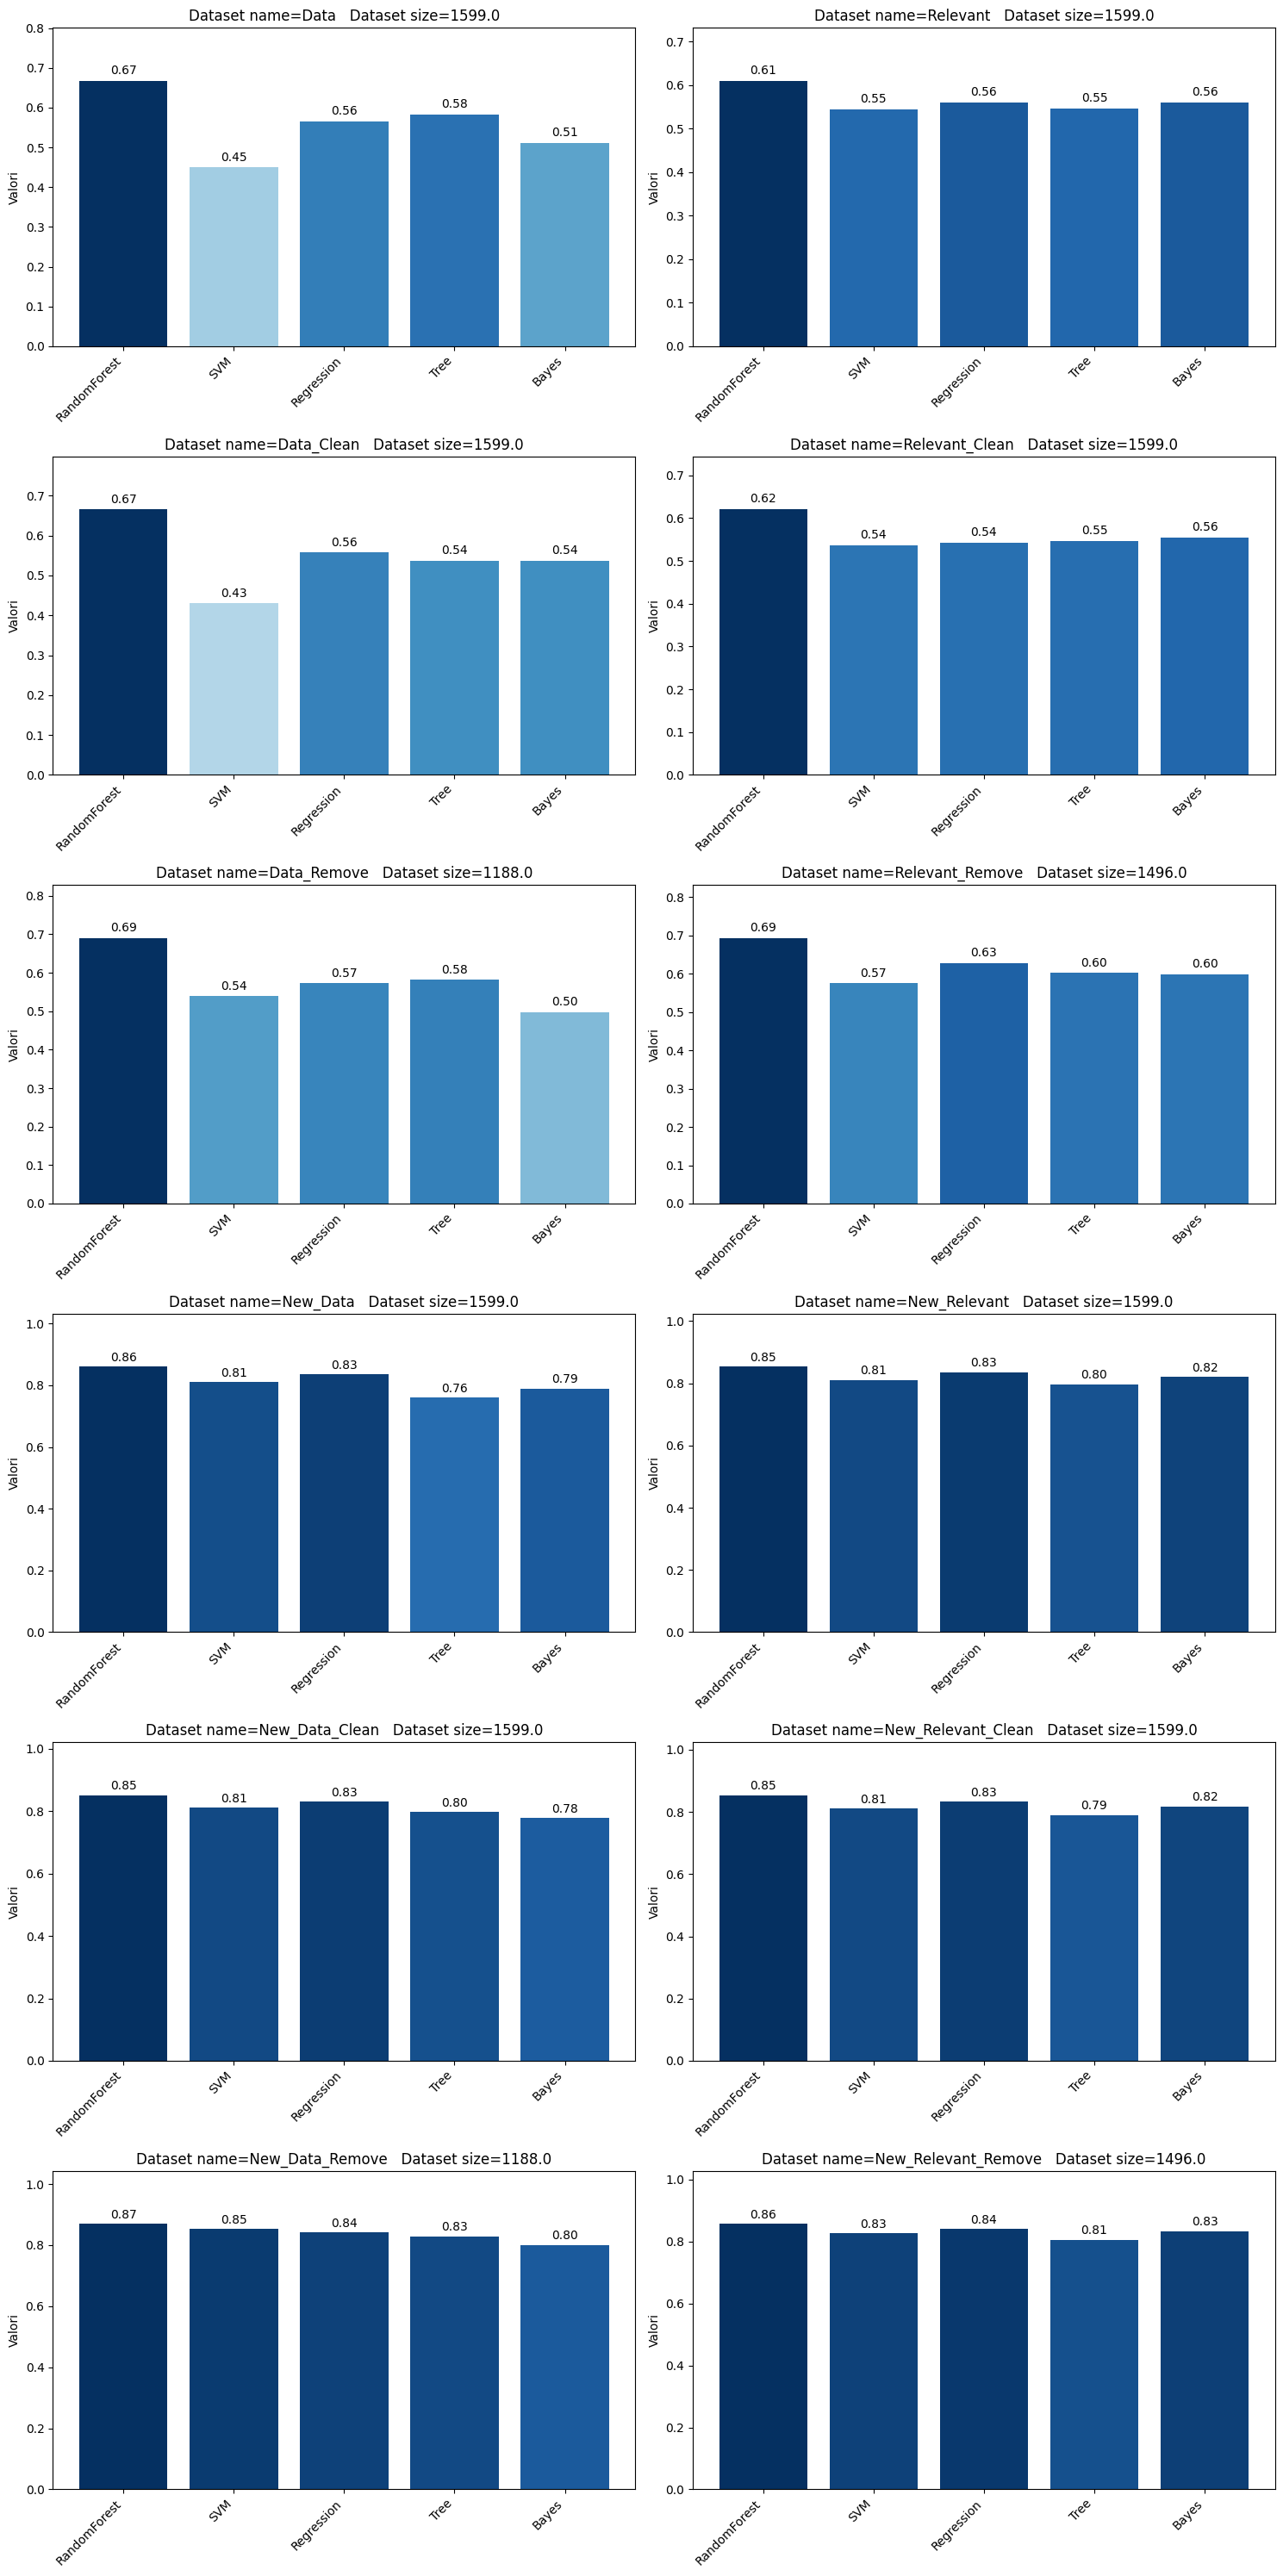

In [73]:
plot_result_evo(result['r_25'])

In [74]:
result['r_30']=classification_evo(data,0.30)

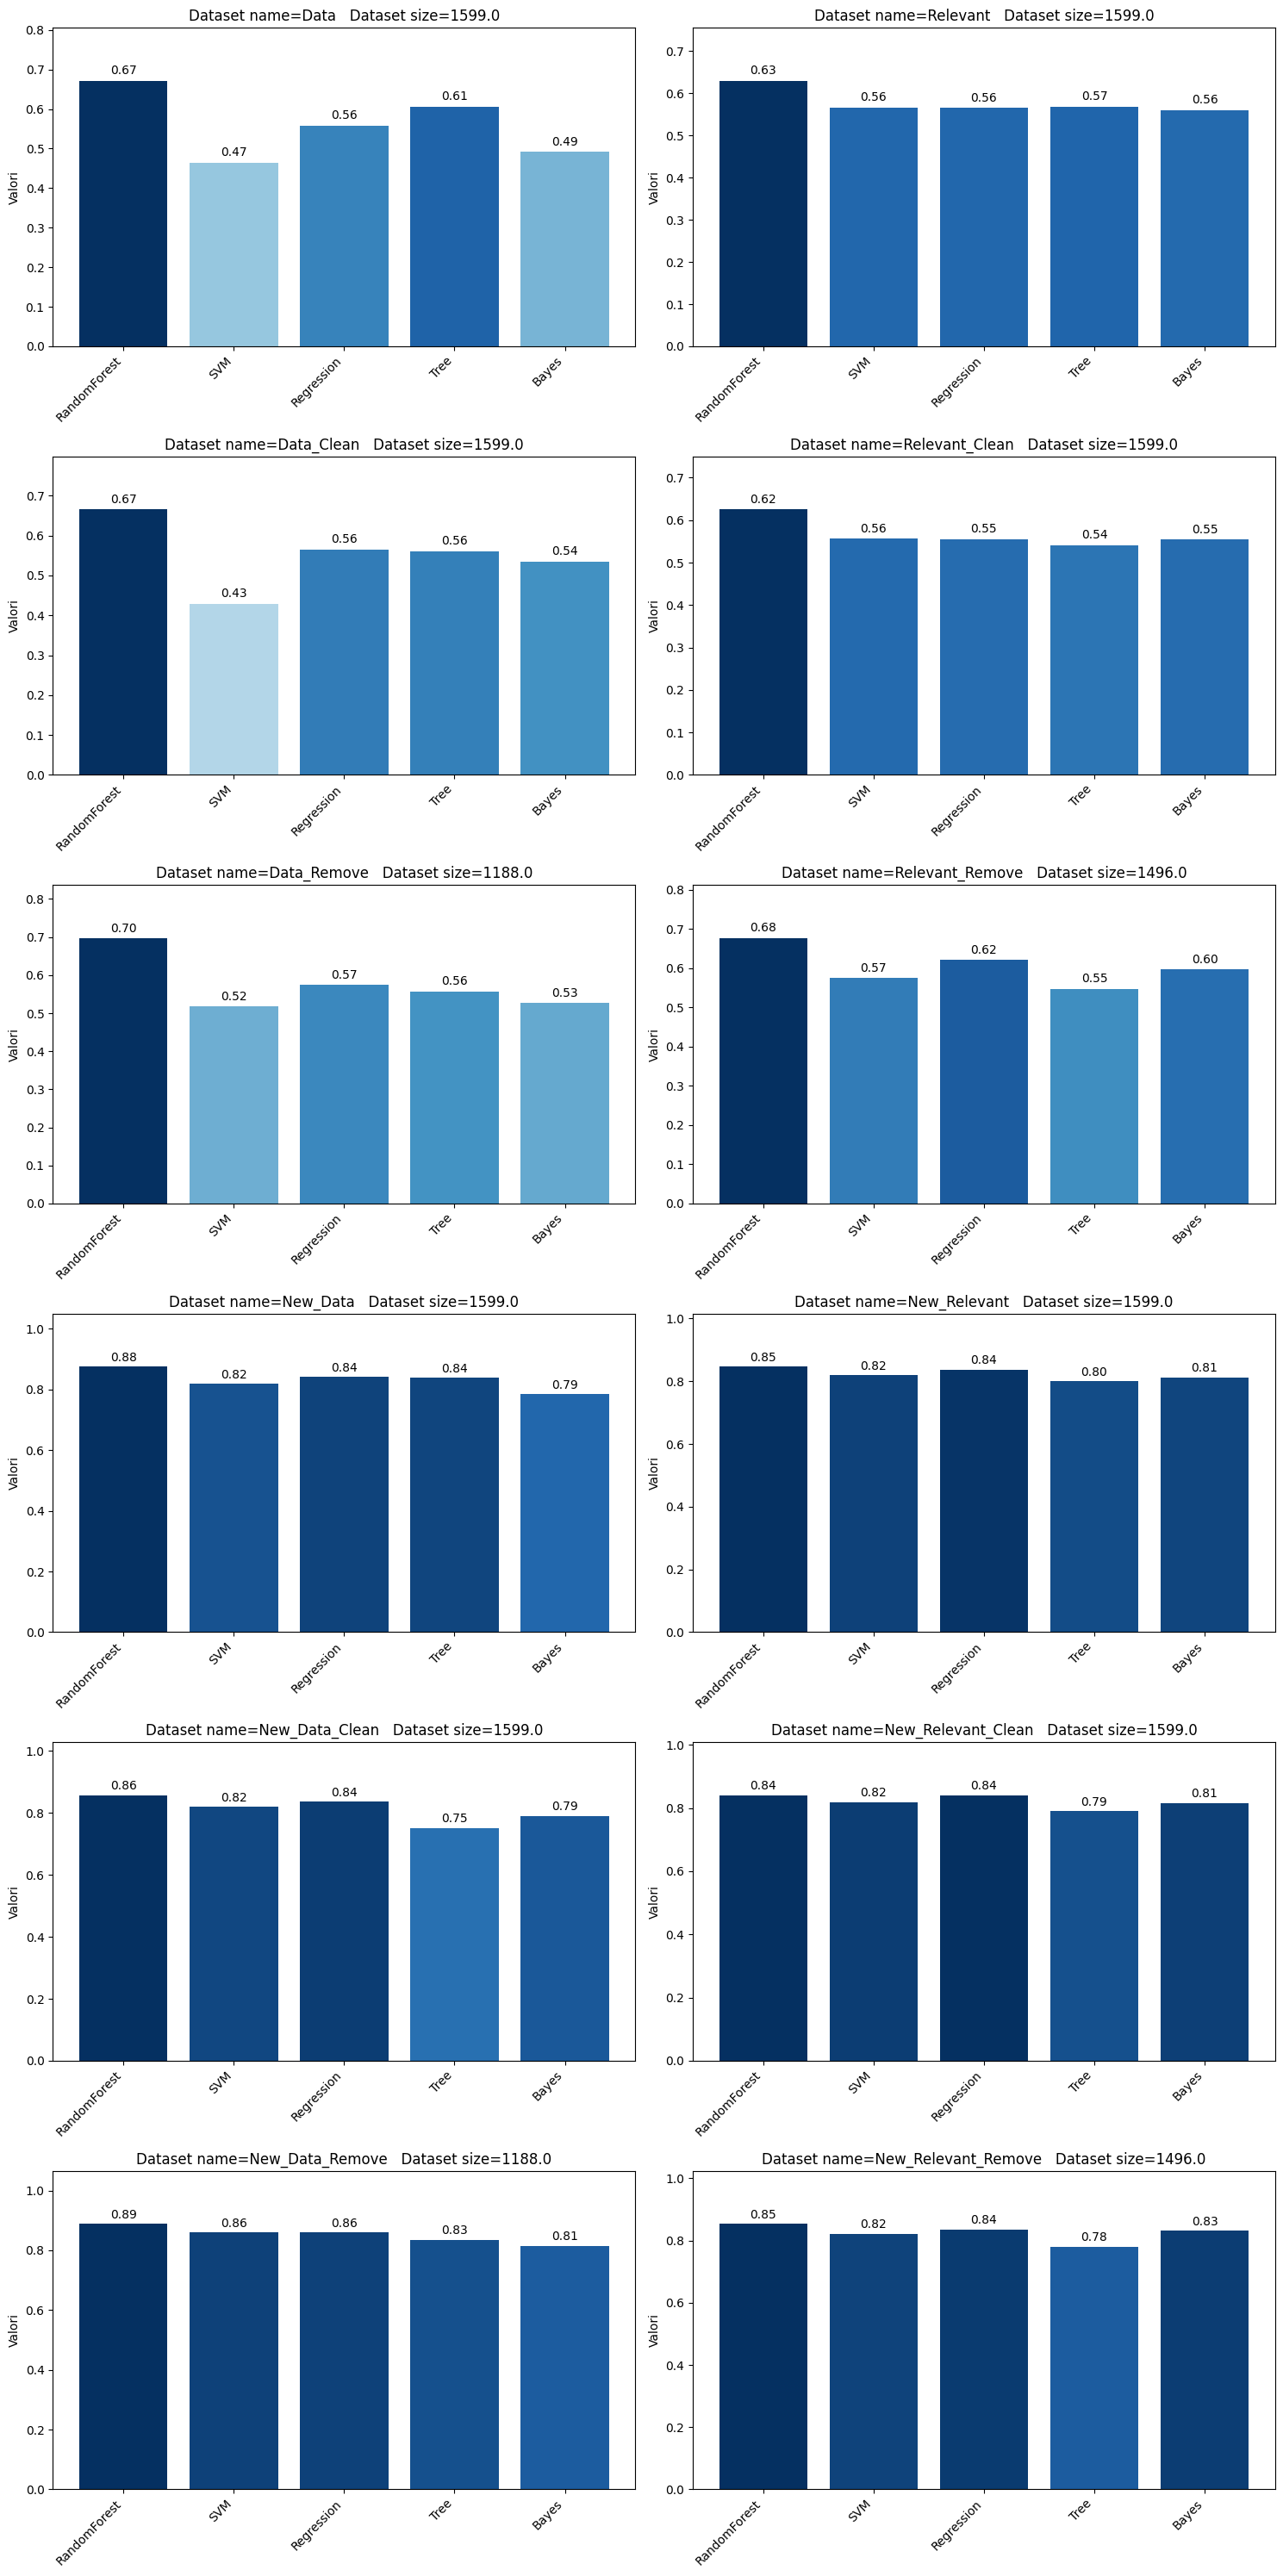

In [75]:
plot_result_evo(result['r_30'])

In [76]:
result['r_40']=classification_evo(data,0.40)

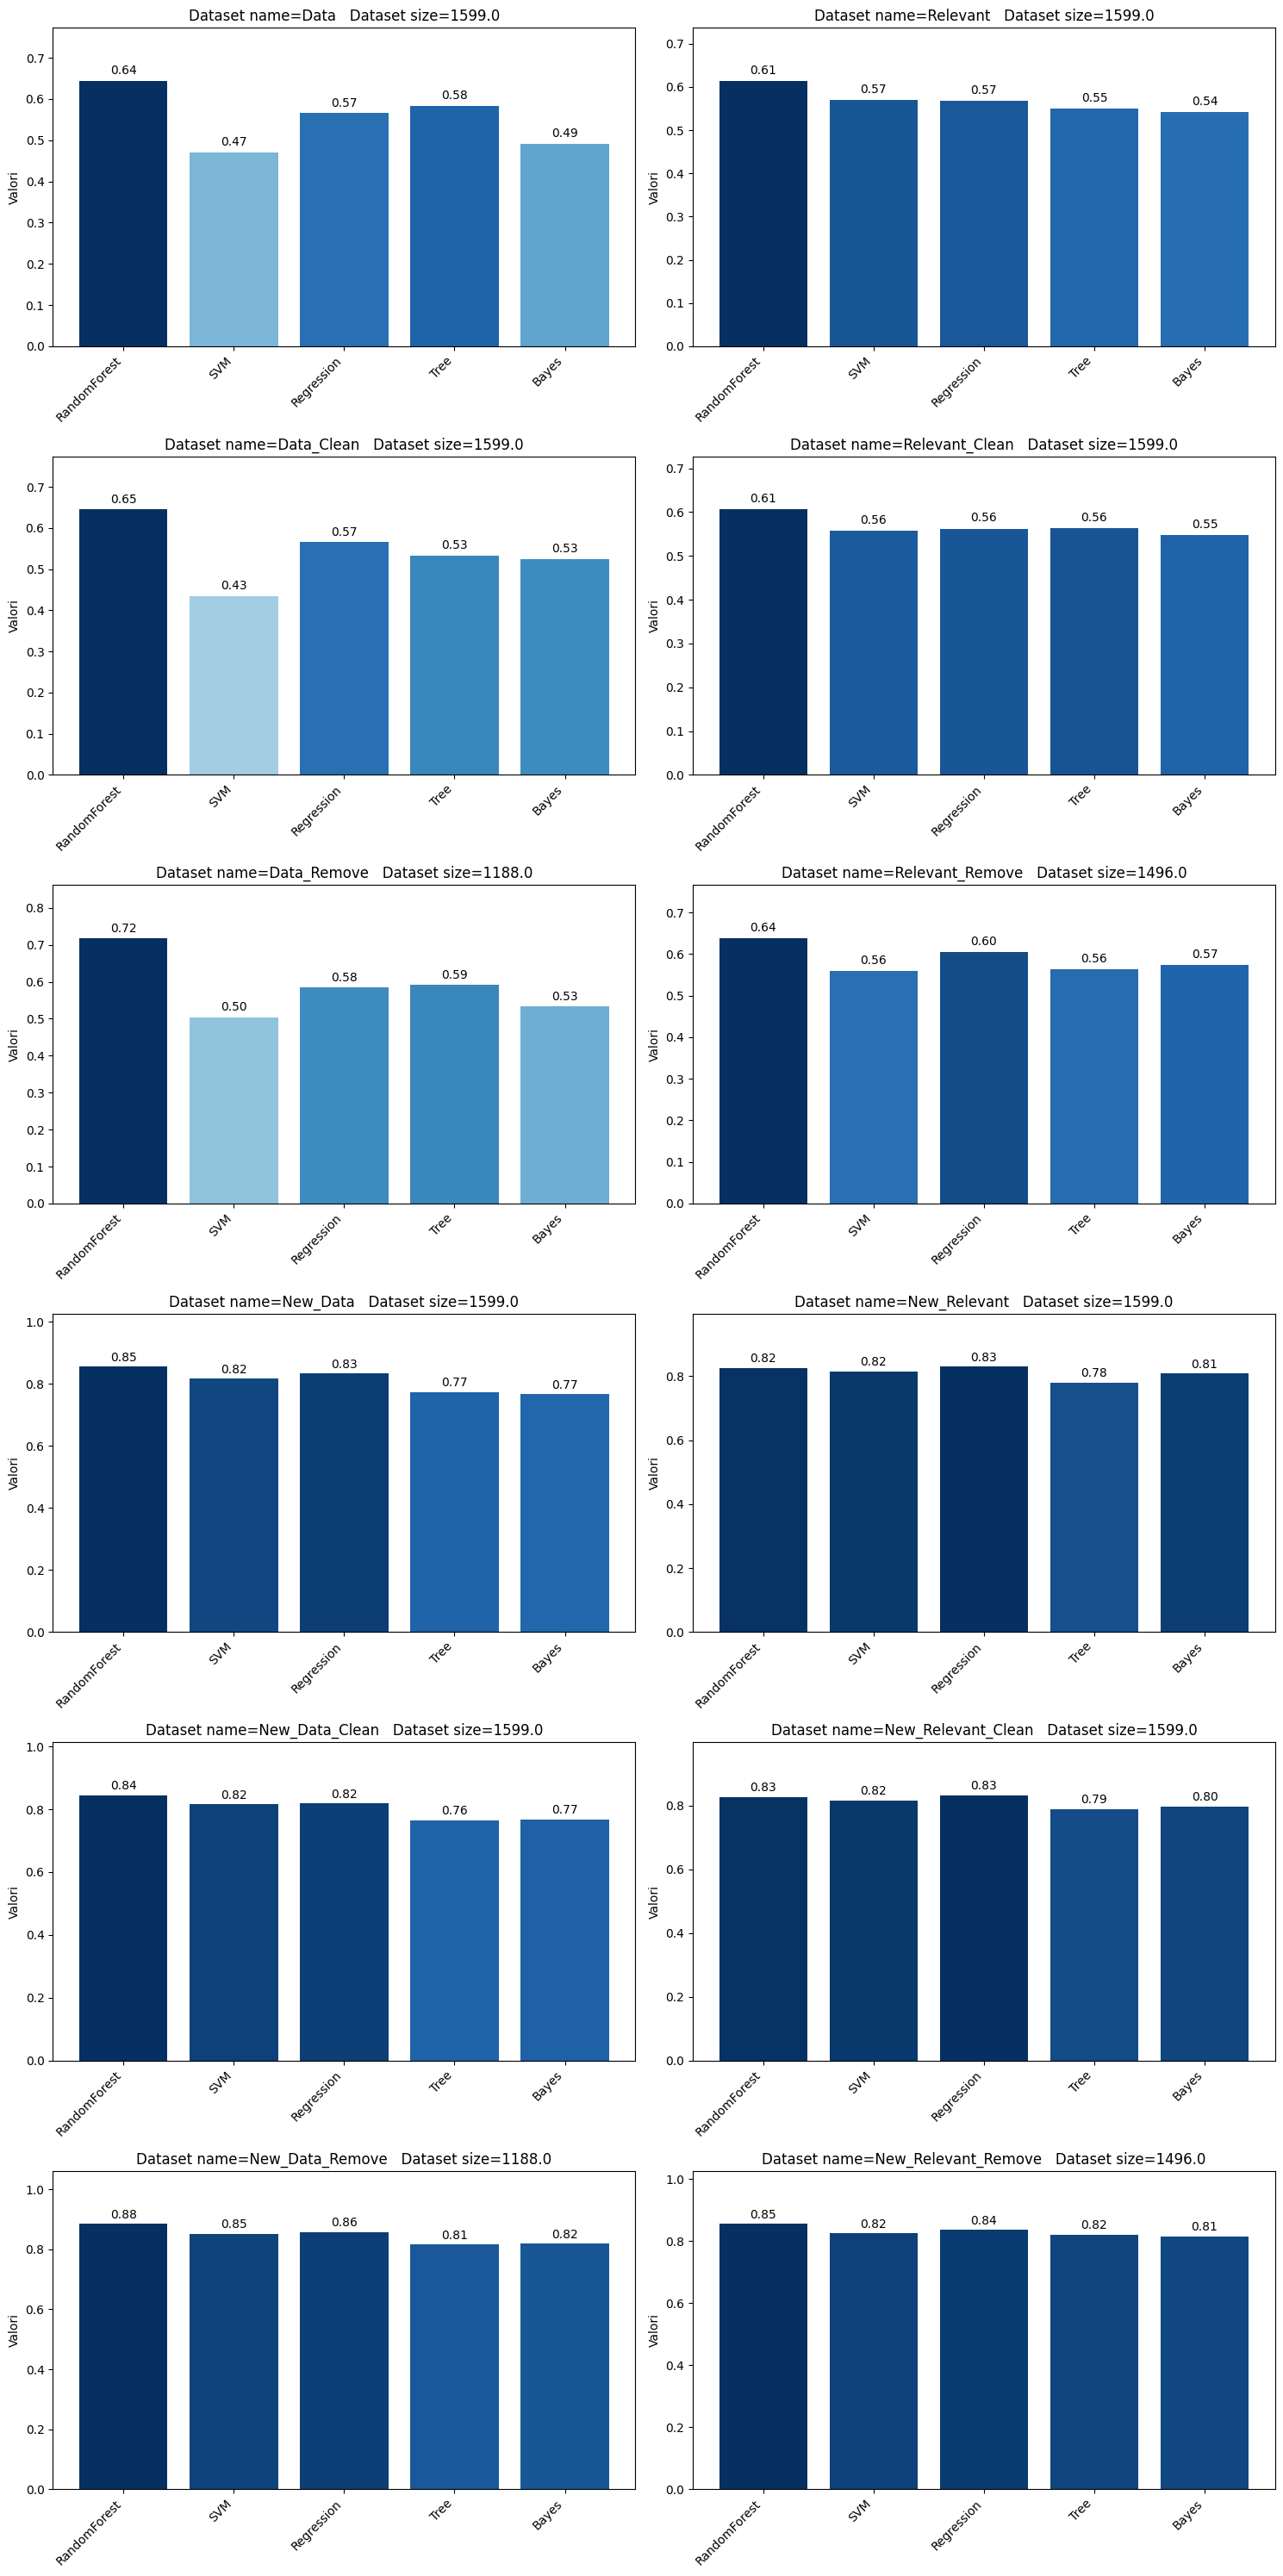

In [77]:
plot_result_evo(result['r_40'])

In [78]:
merged_df = pd.concat([result['r_10'],result['r_15'],result['r_20'],result['r_25'],result['r_30'],result['r_40']],
                       axis=1)

In [79]:
merged_df

,Data,Relevant,Data_Clean,Relevant_Clean,Data_Remove,Relevant_Remove,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean,...,Data_Clean,Relevant_Clean,Data_Remove,Relevant_Remove,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean,New_Data_Remove,New_Relevant_Remove
Type,0.10000,0.10000,0.1000,0.10000,0.100000,0.100000,0.10000,0.100,0.100,0.100,...,0.400000,0.4000,0.400000,0.400000,0.400000,0.400000,0.40000,0.40000,0.400000,0.400000
Size,1599.00000,1599.00000,1599.0000,1599.00000,1188.000000,1496.000000,1599.00000,1599.000,1599.000,1599.000,...,1599.000000,1599.0000,1188.000000,1496.000000,1599.000000,1599.000000,1599.00000,1599.00000,1188.000000,1496.000000
RandomForest,0.67500,0.62500,0.6880,0.66200,0.739000,0.720000,0.89400,0.887,0.875,0.869,...,0.645000,0.6060,0.718000,0.638000,0.855000,0.825000,0.84400,0.82700,0.884000,0.855000
SVM,0.45000,0.59400,0.4060,0.57500,0.546000,0.520000,0.82500,0.825,0.825,0.825,...,0.434000,0.5580,0.504000,0.559000,0.817000,0.816000,0.81600,0.81600,0.851000,0.825000
Regression,0.55625,0.58125,0.5875,0.58125,0.596639,0.566667,0.81875,0.825,0.825,0.825,...,0.565625,0.5625,0.584034,0.604341,0.832812,0.829688,0.81875,0.83125,0.857143,0.836394
Tree,0.58100,0.63100,0.5120,0.59400,0.605000,0.647000,0.82500,0.775,0.787,0.800,...,0.533000,0.5640,0.592000,0.564000,0.773000,0.780000,0.76400,0.78900,0.815000,0.821000
Bayes,0.53100,0.58800,0.5620,0.58100,0.529000,0.567000,0.79400,0.825,0.806,0.838,...,0.525000,0.5470,0.534000,0.574000,0.767000,0.808000,0.76700,0.79700,0.819000,0.815000


In [96]:
completo = merged_df.loc[:, (merged_df == 1599).any()]
completo

,Data,Relevant,Data_Clean,Relevant_Clean,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean,Data,Relevant,...,New_Data_Clean,New_Relevant_Clean,Data,Relevant,Data_Clean,Relevant_Clean,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean
Type,0.10000,0.10000,0.1000,0.10000,0.10000,0.100,0.100,0.100,0.150000,0.150000,...,0.300000,0.300000,0.400000,0.400000,0.400000,0.4000,0.400000,0.400000,0.40000,0.40000
Size,1599.00000,1599.00000,1599.0000,1599.00000,1599.00000,1599.000,1599.000,1599.000,1599.000000,1599.000000,...,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.0000,1599.000000,1599.000000,1599.00000,1599.00000
RandomForest,0.67500,0.62500,0.6880,0.66200,0.89400,0.887,0.875,0.869,0.679000,0.642000,...,0.856000,0.840000,0.644000,0.614000,0.645000,0.6060,0.855000,0.825000,0.84400,0.82700
SVM,0.45000,0.59400,0.4060,0.57500,0.82500,0.825,0.825,0.825,0.446000,0.567000,...,0.819000,0.819000,0.470000,0.570000,0.434000,0.5580,0.817000,0.816000,0.81600,0.81600
Regression,0.55625,0.58125,0.5875,0.58125,0.81875,0.825,0.825,0.825,0.558333,0.570833,...,0.835417,0.839583,0.565625,0.567187,0.565625,0.5625,0.832812,0.829688,0.81875,0.83125
Tree,0.58100,0.63100,0.5120,0.59400,0.82500,0.775,0.787,0.800,0.608000,0.588000,...,0.750000,0.790000,0.583000,0.550000,0.533000,0.5640,0.773000,0.780000,0.76400,0.78900
Bayes,0.53100,0.58800,0.5620,0.58100,0.79400,0.825,0.806,0.838,0.521000,0.583000,...,0.790000,0.815000,0.491000,0.542000,0.525000,0.5470,0.767000,0.808000,0.76700,0.79700


In [105]:
new_completo=completo.drop(index='Size')
new_completo


,Data,Relevant,Data_Clean,Relevant_Clean,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean,Data,Relevant,...,New_Data_Clean,New_Relevant_Clean,Data,Relevant,Data_Clean,Relevant_Clean,New_Data,New_Relevant,New_Data_Clean,New_Relevant_Clean
Type,0.10000,0.10000,0.1000,0.10000,0.10000,0.100,0.100,0.100,0.150000,0.150000,...,0.300000,0.300000,0.400000,0.400000,0.400000,0.4000,0.400000,0.400000,0.40000,0.40000
RandomForest,0.67500,0.62500,0.6880,0.66200,0.89400,0.887,0.875,0.869,0.679000,0.642000,...,0.856000,0.840000,0.644000,0.614000,0.645000,0.6060,0.855000,0.825000,0.84400,0.82700
SVM,0.45000,0.59400,0.4060,0.57500,0.82500,0.825,0.825,0.825,0.446000,0.567000,...,0.819000,0.819000,0.470000,0.570000,0.434000,0.5580,0.817000,0.816000,0.81600,0.81600
Regression,0.55625,0.58125,0.5875,0.58125,0.81875,0.825,0.825,0.825,0.558333,0.570833,...,0.835417,0.839583,0.565625,0.567187,0.565625,0.5625,0.832812,0.829688,0.81875,0.83125
Tree,0.58100,0.63100,0.5120,0.59400,0.82500,0.775,0.787,0.800,0.608000,0.588000,...,0.750000,0.790000,0.583000,0.550000,0.533000,0.5640,0.773000,0.780000,0.76400,0.78900
Bayes,0.53100,0.58800,0.5620,0.58100,0.79400,0.825,0.806,0.838,0.521000,0.583000,...,0.790000,0.815000,0.491000,0.542000,0.525000,0.5470,0.767000,0.808000,0.76700,0.79700


In [93]:
part_1 = merged_df.loc[:, (merged_df == 1496).any()]
part_1

,Relevant_Remove,New_Relevant_Remove,Relevant_Remove,New_Relevant_Remove,Relevant_Remove,New_Relevant_Remove,Relevant_Remove,New_Relevant_Remove,Relevant_Remove,New_Relevant_Remove,Relevant_Remove,New_Relevant_Remove
Type,0.100000,0.100,0.150000,0.150000,0.200,0.200000,0.250000,0.250000,0.300000,0.300000,0.400000,0.400000
Size,1496.000000,1496.000,1496.000000,1496.000000,1496.000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
RandomForest,0.720000,0.847,0.716000,0.862000,0.720,0.867000,0.693000,0.856000,0.677000,0.853000,0.638000,0.855000
SVM,0.520000,0.807,0.573000,0.836000,0.583,0.833000,0.575000,0.826000,0.575000,0.822000,0.559000,0.825000
Regression,0.566667,0.820,0.604444,0.844444,0.640,0.846667,0.628342,0.839572,0.621381,0.835189,0.604341,0.836394
Tree,0.647000,0.840,0.640000,0.836000,0.670,0.840000,0.602000,0.805000,0.548000,0.780000,0.564000,0.821000
Bayes,0.567000,0.813,0.591000,0.836000,0.597,0.827000,0.599000,0.832000,0.597000,0.831000,0.574000,0.815000


In [94]:
part_2 = merged_df.loc[:, (merged_df == 1188).any()]
part_2

,Data_Remove,New_Data_Remove,Data_Remove,New_Data_Remove,Data_Remove,New_Data_Remove,Data_Remove,New_Data_Remove,Data_Remove,New_Data_Remove,Data_Remove,New_Data_Remove
Type,0.100000,0.100000,0.150000,0.150000,0.200000,0.200000,0.250000,0.250000,0.30000,0.300000,0.400000,0.400000
Size,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.00000,1188.000000,1188.000000,1188.000000
RandomForest,0.739000,0.866000,0.732000,0.866000,0.706000,0.861000,0.690000,0.869000,0.69700,0.888000,0.718000,0.884000
SVM,0.546000,0.832000,0.542000,0.821000,0.517000,0.836000,0.539000,0.852000,0.51800,0.860000,0.504000,0.851000
Regression,0.596639,0.823529,0.553073,0.826816,0.542017,0.840336,0.572391,0.841751,0.57423,0.859944,0.584034,0.857143
Tree,0.605000,0.815000,0.592000,0.832000,0.576000,0.815000,0.582000,0.828000,0.55700,0.835000,0.592000,0.815000
Bayes,0.529000,0.756000,0.514000,0.782000,0.513000,0.794000,0.498000,0.801000,0.52700,0.815000,0.534000,0.819000


In [98]:
tot=completo.shape[1]+part_1.shape[1]+part_2.shape[1]
tot

72